Part 2 deserves its own introductory video:

<div class="center">
    <iframe width="100%" height="360" src="https://www.youtube.com/embed/WWONryXA1u8" frameborder="0" allowfullscreen></iframe>
</div>

In this one, you will learn how to create a Neural Network (NN) and use it for deciding whether a student has alcohol consumption problems.

Do students drink too much? How can you predict that? What predicts it best? How much too much is exactly?

Those questions might be difficult to answer, yet we can start somewhere. We can use a very limited dataset to get a sense of what the answers might look like. Something like [this one](https://archive.ics.uci.edu/ml/datasets/STUDENT+ALCOHOL+CONSUMPTION).

The dataset contains 1044 instances and 32 variables (most of which binary and categorical). Actually, it consists of 2 other datasets. The first provides data for students enrolled in Portuguese class. The second describes students enrolled in a math course. There is overlap (yep, I know) between the datasets, that is some students attend both classes.

Let's build an NN model for classifying whether a student has alcohol consumption problem. For that, we will use our trusty old friend - TensorFlow.

Before getting there, we have a bit of dirty work to do. Our dataset is not clean enough to just start and feed the data to our NN model. A bit of wrangling is required. But first, let's start with some setting up:

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from math import floor, ceil
from pylab import rcParams

%matplotlib inline

Some styling and making our experiments reproducible:

In [2]:
sns.set(style='ticks', palette='Spectral', font_scale=1.5)

material_palette = ["#4CAF50", "#2196F3", "#9E9E9E", "#FF9800", "#607D8B", "#9C27B0"]
sns.set_palette(material_palette)
rcParams['figure.figsize'] = 16, 8

plt.xkcd();
random_state = 42
np.random.seed(random_state)
tf.set_random_seed(random_state)

# 1. Preparing the data

Remember, our data is stored in two separate files. Let's load them, assign proper course attendance to each student and merge them into one:

In [3]:
math_df = pd.read_csv("data/student/student-mat.csv", sep=";")
port_df = pd.read_csv("data/student/student-por.csv", sep=";")

math_df["course"] = "math"
port_df["course"] = "portuguese"

merged_df = math_df.append(port_df)
merged_df.shape

(1044, 34)

Exactly as promised - 1044 rows, but we have duplicates. The dataset archive contains instructions on how to find them. The merged result contains 382 instances. We will update the course column for those students, too:

In [4]:
merge_vector = ["school","sex","age","address",
                "famsize","Pstatus","Medu","Fedu",
                "Mjob","Fjob","reason","nursery","internet"]

duplicated_mask = merged_df.duplicated(keep=False, subset=merge_vector)
duplicated_df = merged_df[duplicated_mask]
unique_df = merged_df[~duplicated_mask]
both_courses_mask = duplicated_df.duplicated(subset=merge_vector)
both_courses_df = duplicated_df[~both_courses_mask].copy()
both_courses_df["course"] = "both"
students_df = unique_df.append(both_courses_df)

We will use the following formula to quantify the amount of alcohol taken during the week per student:

$$Alcohol=\frac{Walc \times 2 \,+\, Dalc \times 5}{7}$$

The new value changes in the interval $[1, 5]$. Furthermore, we will classify student as a drinker if that value is greater than 2.

In [5]:
students_df = students_df.sample(frac=1)
students_df['alcohol'] = (students_df.Walc * 2 + students_df.Dalc * 5) / 7
students_df['alcohol'] = students_df.alcohol.map(lambda x: ceil(x))
students_df['drinker'] = students_df.alcohol.map(lambda x: "yes" if x > 2 else "no")

# 2. Exploration

Finally, we can get a feel for our data. Let's take a look at the course distribution:

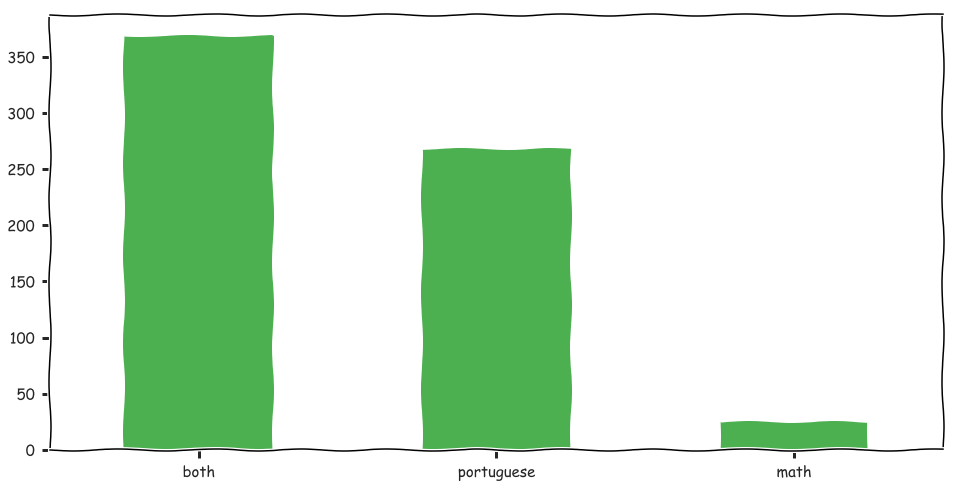

In [6]:
students_df.course.value_counts().plot(kind="bar", rot=0);

And the alcohol consumption from the formula:

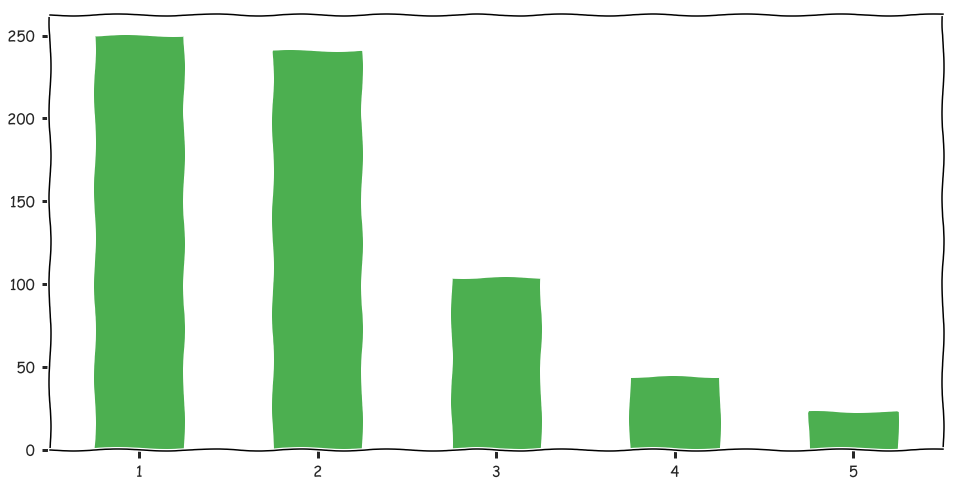

In [7]:
students_df.alcohol.value_counts().plot(kind="bar", rot=0);

The actual variable that we are going to predict:

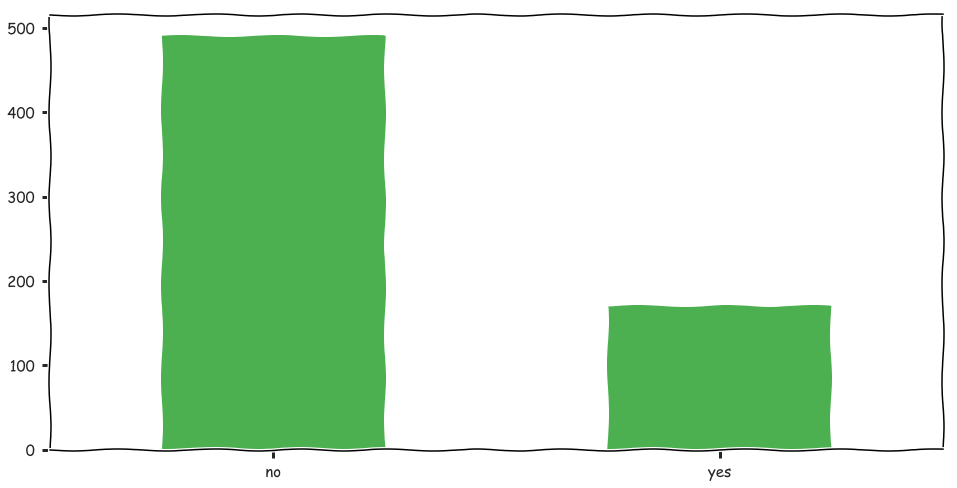

In [8]:
students_df.drinker.value_counts().plot(kind="bar", rot=0);

Somewhat more comprehensive overview:

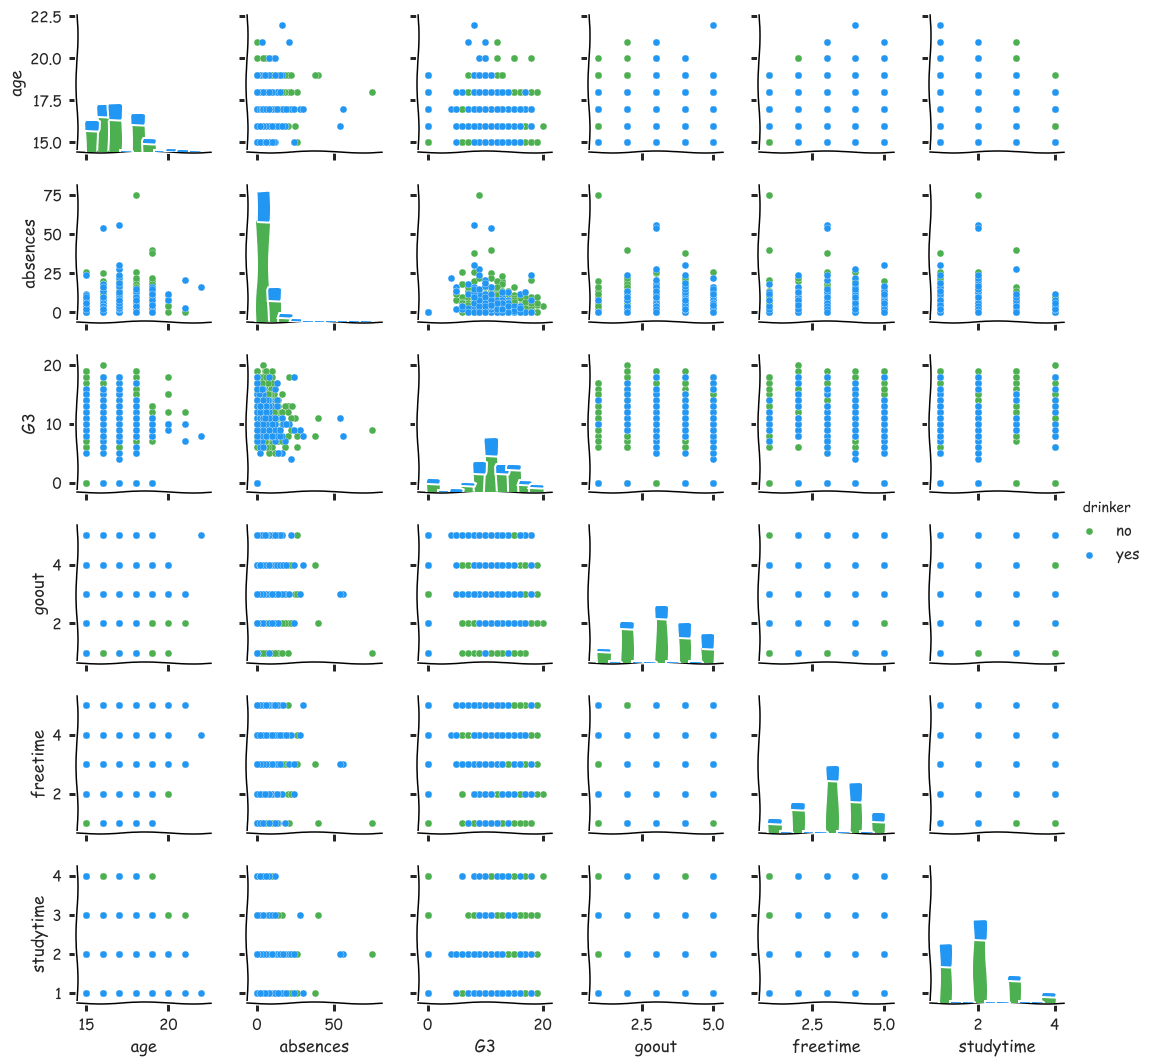

In [9]:
sns.pairplot(students_df[['age', 'absences', 'G3', 'goout', 'freetime', 'studytime', 'drinker']], hue='drinker');

Let's have a look at a general correlations matrix:

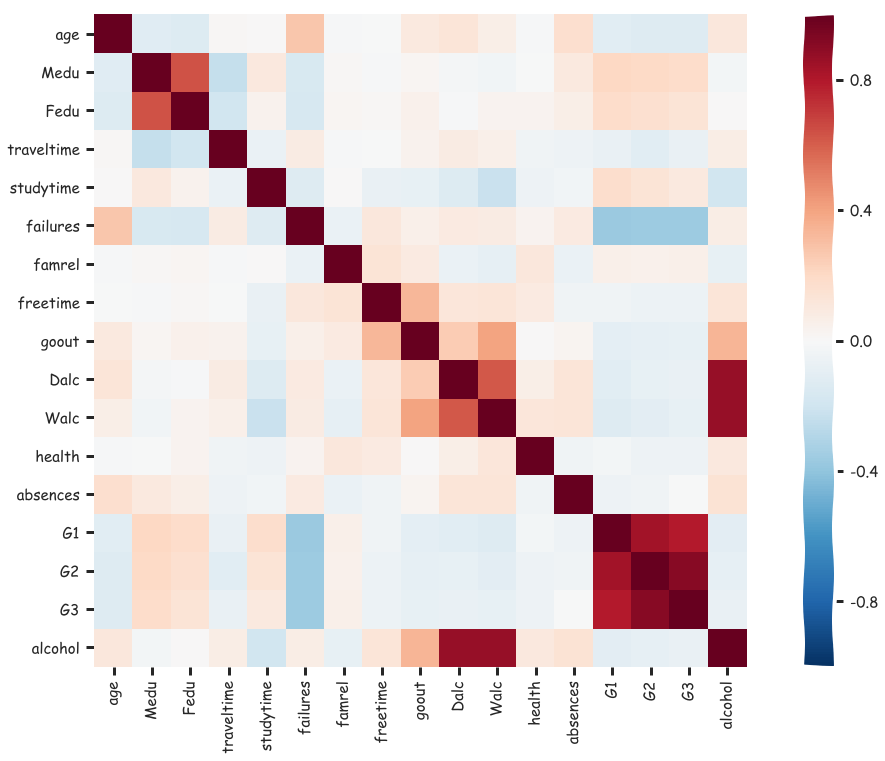

In [28]:
corr_mat = students_df.corr()
fig, ax = plt.subplots(figsize=(20, 12))
sns.heatmap(corr_mat, vmax=1.0, square=True, ax=ax);

# 3. Building our model

It is time for the fun part. Well, not just yet.

## 3.1 Encoding the data

Most of our variables are categorical and we must one-hot encode them four our NN to work properly. First, let's define a little helper function:

In [11]:
def encode(series):
    return pd.get_dummies(series.astype(str))

Our features and target variable using our little helper function:

In [12]:
train_x = pd.get_dummies(students_df.school)
train_x['age'] = students_df.age
train_x['absences'] = students_df.absences
train_x['g1'] = students_df.G1
train_x['g2'] = students_df.G2
train_x['g3'] = students_df.G3
train_x = pd.concat([train_x, encode(students_df.sex), encode(students_df.Pstatus), 
                     encode(students_df.Medu), encode(students_df.Fedu),
                     encode(students_df.guardian), encode(students_df.studytime),
                     encode(students_df.failures), encode(students_df.activities),
                     encode(students_df.higher), encode(students_df.romantic),
                     encode(students_df.reason), encode(students_df.paid),
                     encode(students_df.goout), encode(students_df.health),
                     encode(students_df.famsize), encode(students_df.course)
                    ], axis=1)

train_y = encode(students_df.drinker)

## 3.2 Splitting the data

Let's allocate 90% of the data for training and use 10% for testing:

In [16]:
train_size = 0.9

train_cnt = floor(train_x.shape[0] * train_size)
x_train = train_x.iloc[0:train_cnt].values
y_train = train_y.iloc[0:train_cnt].values
x_test = train_x.iloc[train_cnt:].values
y_test = train_y.iloc[train_cnt:].values

## 3.3 Building our Neural Network

Our NN consists of input, output and 1 hidden layer. We are using ReLU as activation function of the hidden layer and softmax for our output layer. As an additional bonus we will use Dropout - simple way to reduce overfitting during the training of our network. Let's wrap our model in a little helper function:

In [30]:
def multilayer_perceptron(x, weights, biases, keep_prob):
    layer_1 = tf.add(tf.matmul(x, weights['h1']), biases['b1'])
    layer_1 = tf.nn.relu(layer_1)
    layer_1 = tf.nn.dropout(layer_1, keep_prob)
    out_layer = tf.matmul(layer_1, weights['out']) + biases['out']
    return out_layer

Let's set the number of neurons in the hidden layer to 38 and randomly initialize the weights and biases considering their proper dimensions:

In [29]:
n_hidden_1 = 38
n_input = train_x.shape[1]
n_classes = train_y.shape[1]

weights = {
    'h1': tf.Variable(tf.random_normal([n_input, n_hidden_1])),
    'out': tf.Variable(tf.random_normal([n_hidden_1, n_classes]))
}

biases = {
    'b1': tf.Variable(tf.random_normal([n_hidden_1])),
    'out': tf.Variable(tf.random_normal([n_classes]))
}

keep_prob = tf.placeholder("float")

We will train our model for 5,000 epochs (training steps) with a batch size of 32. That is, at each step, we will train our NN using 32 rows of our data. Granted, in our case you can just train on the whole dataset. However, when the data is huge and you can't fit it in memory, you would love to split it and feed it to the model at batches (chunks):

In [18]:
training_epochs = 5000
display_step = 1000
batch_size = 32

x = tf.placeholder("float", [None, n_input])
y = tf.placeholder("float", [None, n_classes])

## 3.4 Training

In order for our model to learn, we need to define what is good. Actually, we will define what is bad and try to minimize it. We will call the "badness" - error or cost (hence, the cost function). It represents how far off of the true result our model is at some point during training. We would love that error to be 0 for all possible inputs. Currently, that happens only in Sci-Fi novels (not that I discourage dreaming about it).

The cost function that we are going to use is called "Cross-Entropy". It is defined as:

$$H_{y'}(y) = -\sum_i y'_i \log(y_i)$$

Where $y$ is the predicted distribution for our alcohol consumption and $y'$ is the ground truth. [This guide](https://colah.github.io/posts/2015-09-Visual-Information/) might be helpful for better understanding Cross-Entropy. TensorFlow has a little helper function with the sweet little name <code>softmax_cross_entropy_with_logits</code>. It use softmax as activation function for our output layer and use Cross-Entropy as error function.

In [33]:
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=predictions, labels=y))

Now, for the actual workhorse - Adam (nope, not the from the Bible - although, that would've been fun). Adam is a type of gradient descent optimization algorithm which essentially tries as hard as he can to find proper weights and biases for our network via minimizing the cost function that we specified above. It is well beyond the scope of this post to describe Adam in details, but you can find all the necessary information [over here](http://sebastianruder.com/optimizing-gradient-descent/) - with tons of nice pictures!

Using Adam in TensorFlow is quite easy, we just have to specify learning rate (you can fiddle with that one) and pass the cost function we defined above:

In [ ]:
optimizer = tf.train.AdamOptimizer(learning_rate=0.0001).minimize(cost)

Our model is created by just calling our helper function with the proper arguments:

In [31]:
predictions = multilayer_perceptron(x, weights, biases, keep_prob)

Our finished NN looks something like this (much reduced input and hidden layer sizes):

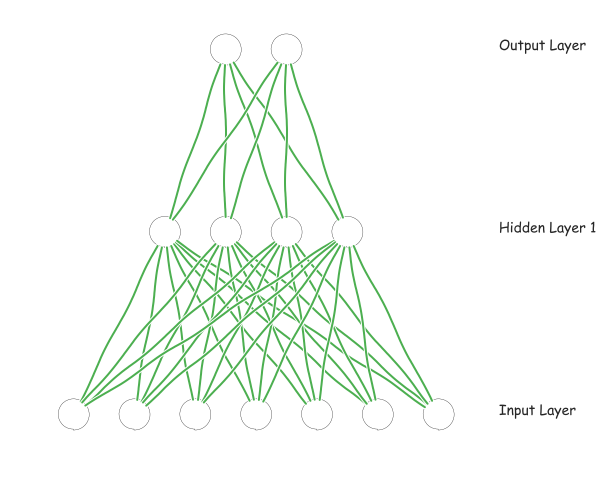

In [21]:
from math import cos, sin, atan


class Neuron():
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def draw(self, neuron_radius):
        circle = plt.Circle((self.x, self.y), radius=neuron_radius, fill=False)
        plt.gca().add_patch(circle)


class Layer():
    def __init__(self, network, number_of_neurons, number_of_neurons_in_widest_layer):
        self.vertical_distance_between_layers = 6
        self.horizontal_distance_between_neurons = 2
        self.neuron_radius = 0.5
        self.number_of_neurons_in_widest_layer = number_of_neurons_in_widest_layer
        self.previous_layer = self.__get_previous_layer(network)
        self.y = self.__calculate_layer_y_position()
        self.neurons = self.__intialise_neurons(number_of_neurons)

    def __intialise_neurons(self, number_of_neurons):
        neurons = []
        x = self.__calculate_left_margin_so_layer_is_centered(number_of_neurons)
        for iteration in range(number_of_neurons):
            neuron = Neuron(x, self.y)
            neurons.append(neuron)
            x += self.horizontal_distance_between_neurons
        return neurons

    def __calculate_left_margin_so_layer_is_centered(self, number_of_neurons):
        return self.horizontal_distance_between_neurons * (self.number_of_neurons_in_widest_layer - number_of_neurons) / 2

    def __calculate_layer_y_position(self):
        if self.previous_layer:
            return self.previous_layer.y + self.vertical_distance_between_layers
        else:
            return 0

    def __get_previous_layer(self, network):
        if len(network.layers) > 0:
            return network.layers[-1]
        else:
            return None

    def __line_between_two_neurons(self, neuron1, neuron2):
        angle = atan((neuron2.x - neuron1.x) / float(neuron2.y - neuron1.y))
        x_adjustment = self.neuron_radius * sin(angle)
        y_adjustment = self.neuron_radius * cos(angle)
        line = plt.Line2D((neuron1.x - x_adjustment, neuron2.x + x_adjustment), (neuron1.y - y_adjustment, neuron2.y + y_adjustment))
        plt.gca().add_line(line)

    def draw(self, layerType=0):
        for neuron in self.neurons:
            neuron.draw( self.neuron_radius )
            if self.previous_layer:
                for previous_layer_neuron in self.previous_layer.neurons:
                    self.__line_between_two_neurons(neuron, previous_layer_neuron)
        # write Text
        x_text = self.number_of_neurons_in_widest_layer * self.horizontal_distance_between_neurons
        if layerType == 0:
            plt.text(x_text, self.y, 'Input Layer', fontsize = 14)
        elif layerType == -1:
            plt.text(x_text, self.y, 'Output Layer', fontsize = 14)
        else:
            plt.text(x_text, self.y, 'Hidden Layer '+str(layerType), fontsize = 14)

class NeuralNetwork():
    def __init__(self, number_of_neurons_in_widest_layer):
        self.number_of_neurons_in_widest_layer = number_of_neurons_in_widest_layer
        self.layers = []
        self.layertype = 0

    def add_layer(self, number_of_neurons ):
        layer = Layer(self, number_of_neurons, self.number_of_neurons_in_widest_layer)
        self.layers.append(layer)

    def draw(self):
        plt.figure()
        for i in range( len(self.layers) ):
            layer = self.layers[i]
            if i == len(self.layers)-1:
                i = -1
            layer.draw( i )
        plt.axis('scaled')
        plt.axis('off')
        plt.show()

class DrawNN():
    def __init__( self, neural_network ):
        self.neural_network = neural_network

    def draw( self ):
        widest_layer = max( self.neural_network )
        network = NeuralNetwork( widest_layer )
        for l in self.neural_network:
            network.add_layer(l)
        network.draw()
        
network = DrawNN( [7,4,2] )
network.draw()

# 4. Evaluation

Time to see how well our model can predict. During the training, we will set the keep probability of the Dropout to 0.8 and reset it to 1.0 during test time:

In [22]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    for epoch in range(training_epochs):
        avg_cost = 0.0
        total_batch = int(len(x_train) / batch_size)
        x_batches = np.array_split(x_train, total_batch)
        y_batches = np.array_split(y_train, total_batch)
        for i in range(total_batch):
            batch_x, batch_y = x_batches[i], y_batches[i]
            _, c = sess.run([optimizer, cost], feed_dict={x: batch_x,
                                                          y: batch_y, keep_prob: 0.8})
            avg_cost += c / total_batch
        if epoch % display_step == 0:
            print("Epoch:", '%04d' % (epoch+1), "cost=", \
                "{:.9f}".format(avg_cost))

    print("Optimization Finished!")

    correct_prediction = tf.equal(tf.argmax(predictions, 1), tf.argmax(y, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
    print("Accuracy:", accuracy.eval({x: x_test, y: y_test, keep_prob: 1.0}))

Epoch: 0001 cost= 103.346587711
Epoch: 1001 cost= 2.053295698
Epoch: 2001 cost= 0.464109008
Epoch: 3001 cost= 0.304592287
Epoch: 4001 cost= 0.284183074
Optimization Finished!
Accuracy: 0.731343


# 5. Conclusion(s)

Yes, you did it! You survived another part of this tutorial. But what did you achieved? Our model got roughly 73% accuracy on the test set. Is this good? Well... no, it is not!

How is that possible? The authors of the paper linked from the dataset attained 92% accuracy. Which is (as they state) acceptable. So, why our model performs so badly?

For one thing, we excluded overlapping student data, which made our dataset considerably smaller - from 1044 to just 662 instances (I haven't found any type of duplicate reduction technique used by the authors. Please, write me a comment if I am wrong about that one). Due to the high prevalence of no drinkers, this might have a decremental effect on our model performance.

Of course, you can try different parameters, architecture, training epochs etc... Feel free to do so! Till next time!

# References

[Student Alcohol Consumption](https://archive.ics.uci.edu/ml/datasets/STUDENT+ALCOHOL+CONSUMPTION) - Description of the used dataset<br/>
[Using Data Mining to Predict Secondary School Student Alcohol Consumption](https://www.researchgate.net/publication/296695247_USING_DATA_MINING_TO_PREDICT_SECONDARY_SCHOOL_STUDENT_ALCOHOL_CONSUMPTION) - A paper using this dataset and comparing 3 different models on it (including NN)<br/>
[Student Alcohol Consumption Prediction](https://github.com/aman181993/student-alcohol-consumption-prediction) - Possibly source code used in the previous paper<br/>
[MNIST classification using TensorFlow](https://github.com/aymericdamien/TensorFlow-Examples/blob/master/notebooks/3_NeuralNetworks/multilayer_perceptron.ipynb) - Use Deep Neural Network to classify handwritten digits<br/>
[How to choose the number of hidden layers and neurons in NN?](https://stats.stackexchange.com/questions/181/how-to-choose-the-number-of-hidden-layers-and-nodes-in-a-feedforward-neural-netw/1097#1097)<br/>
[How to handle ordinal data in NN models](https://arxiv.org/abs/0704.1028) - Lots of the variables are ordinal. This paper presents an approach to handling that kind of data in NN models<br/>
[Simpler way to handle ordinal data in NN models](https://stackoverflow.com/questions/38375401/neural-network-ordinal-classification-for-age)